In [68]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
from pathlib import Path
import itertools
from IPython.display import display, HTML
from collections import namedtuple

In [69]:
def get_markers_colors():
    markers = itertools.cycle(['o', 's', '^', 'x', 'v', '+', 'D', '8', '*', 'p', '<', '>', 'd', 'H'])
    colors = itertools.cycle(['tab:blue', 'tab:orange', 'tab:green', 'tab:red', 'tab:purple', 'tab:brown', 'tab:pink', 'tab:gray', 'tab:olive', 'tab:cyan'])
    return markers, colors


def reload_data():
    p = Path("../new_data/").glob('*.csv')

    op2df = {x.name.split('.')[0]:
             pd.read_csv(x, index_col=0)
                 for x in p if x.is_file()}

    all_ops = list(op2df.keys())
    return op2df, all_ops


def _split_column(df, i=None, col=None, delim_colname=", ", delim_values=" "):
    cols = df.columns.to_list()
    if col is None:
        assert i is not None, "`i` and `col` cannot both be None"
        col = cols[i]
    df[col.split(delim_colname)] = df[col].str.split(delim_values, expand=True)#.astype(float, errors='ignore')
    df = df.drop(columns=col)
    return df.convert_dtypes()


def split_time_col(df):
    df = df.rename(columns={"GPU clock time": "GPU clock time|GPU clock time PT"})
    df = _split_column(df, i=None, col="GPU clock time|GPU clock time PT", delim_colname="|", delim_values=" ")
    df["GPU clock time PT"] = df["GPU clock time PT"].str.replace("(\(|\))", "", regex=True)
    return df.astype({"GPU clock time": float, "GPU clock time PT": float})


def split_column(df, i=None, col=None, delim_colname=", ", delim_values=" "):
    df = _split_column(df, i=i, col=col, delim_colname=delim_colname, delim_values=delim_values)
    if not pd.api.types.is_numeric_dtype(df["GPU clock time"]):
        df = split_time_col(df)
    return df


def plot_operation(df, 
                   plots_cols, 
                   curves_cols, 
                   x_col="Sparsity", 
                   y_col='GPU clock time', 
                   op_name=None):
    """
    x_col = "Sparsity"
    y_col = ['GPU clock time']
    plots_cols = ['shape']
    curves_cols = ["Reduce factor"]
    """
    try:
        df = df.set_index(x_col)
    except KeyError:
        pass

    if isinstance(y_col, str):
        y_col = [c for c in df.columns if y_col in c]
        
    if plots_cols is None:
        GrObj = namedtuple('GrObj', 'ngroups groups get_group')
        grouped = GrObj(ngroups=1, groups={"": ""}, get_group=(lambda x: df))
    else:
        grouped = df.groupby(plots_cols)

    if grouped.ngroups <= 4:
        ncols = grouped.ngroups
        nrows = 1
    else:
        ncols = 4
        nrows = int(np.ceil(grouped.ngroups/ncols))
    
    fig, axes = plt.subplots(nrows=nrows, ncols=ncols, figsize=(6 * ncols, 4.5 * nrows)) #, sharey=True
    try: 
        axes = axes.flatten()
    except AttributeError:
        axes = [axes]
    fig.suptitle(op_name, fontsize=16)
    
    for (key, ax) in zip(grouped.groups.keys(), axes):
        markers, colors = get_markers_colors()
        gr = grouped.get_group(key)
        gr_curves = gr.groupby(curves_cols)
        for gr_curves_key in gr_curves.groups.keys():
            marker = next(markers)
            color = next(colors)
            for i,y in enumerate(y_col):
                gr_curves.get_group(gr_curves_key)[y].plot(marker=marker, 
                                                           color=color, 
                                                           ax=ax, 
                                                           label=gr_curves_key if i==0 else '_nolegend_', 
                                                           linestyle="-" if i==0 else "--",
                                                           alpha=0.99)
                if i == 0:
                    ax.set_ylabel(y)
        ax.legend(title=f"{','.join(curves_cols)}")
        ax.set_title(f"{key}")

    plt.tight_layout()
    plt.show()


In [70]:
op2df, all_ops = reload_data()
all_ops

['native_sort',
 'scatter_max',
 'scatter_min',
 'scatter_mean',
 'scatter_add',
 'scatter_multiply',
 'native_addmm',
 'native_index_add_',
 'native_gather',
 'sparse_spmm',
 'sparse_spspmm',
 'sparse_transpose',
 'native_index_select']

In [71]:
!ls -l ../new_data/

total 240
-rw-r--r-- 1 rhosseini users 16633 Apr 13 14:21 native_addmm.csv
-rw-r--r-- 1 rhosseini users  1293 Apr 13 14:27 native_gather.csv
-rw-r--r-- 1 rhosseini users  1287 Apr 13 14:23 native_index_add_.csv
-rw-r--r-- 1 rhosseini users  5285 Apr 13 16:08 native_index_select.csv
-rw-r--r-- 1 rhosseini users  2729 Apr 13 13:41 native_sort.csv
-rw-r--r-- 1 rhosseini users  1498 Apr 13 14:01 scatter_add.csv
-rw-r--r-- 1 rhosseini users  1304 Apr 13 15:30 scatter_max.csv
-rw-r--r-- 1 rhosseini users  1240 Apr 13 13:58 scatter_mean.csv
-rw-r--r-- 1 rhosseini users  1238 Apr 13 13:54 scatter_min.csv
-rw-r--r-- 1 rhosseini users  1231 Apr 13 14:04 scatter_multiply.csv
-rw-r--r-- 1 rhosseini users  2475 Apr 13 14:33 sparse_spmm.csv
-rw-r--r-- 1 rhosseini users  2493 Apr 13 14:34 sparse_spspmm.csv
-rw-r--r-- 1 rhosseini users   522 Apr 13 14:35 sparse_transpose.csv


In [72]:
for op,df in op2df.items():
    print(op, df.columns.to_list())

native_sort ['Input dims, sort dim, stable', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_max ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time', 'IQR']
scatter_min ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_mean ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_add ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
scatter_multiply ['Reduce factor, shape', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
native_addmm ['Input dims', 'Input size (>95% mem util)*', 'Sparsities (input, matA, matB)', 'GPU clock time']
native_index_add_ ['Input dims, index dim', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
native_gather ['Input dims, index dim', 'Input size (>95% mem util)*', 'Sparsity', 'GPU clock time']
sparse_spmm ['Input dims', 'Input size (>95% mem util)*', 'Sparsities (inp

# plots

## `scatter_` and `spline_`

'scatter_max'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time,IQR
0,8 square,"(38000, 38000)",0.99,0.638,0
1,8 LS,"(1472353280,)",0.99,0.628,0
2,8 square,"(38000, 38000)",0.90,0.635,0


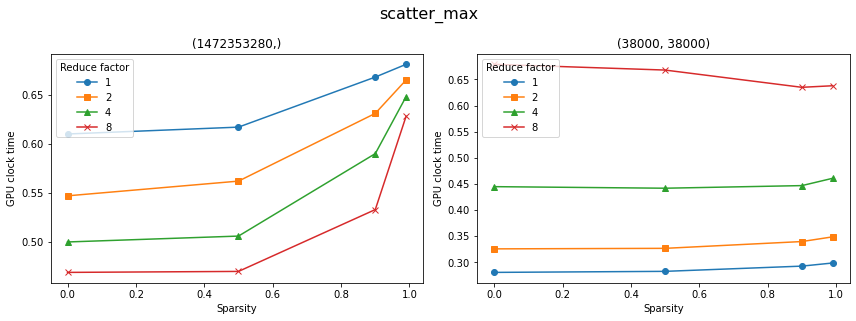

'scatter_min'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(1472353280,)",0.0,0.603
1,1 square,"(38000, 38000)",0.0,0.282
2,1 LS,"(1472353280,)",0.5,0.632


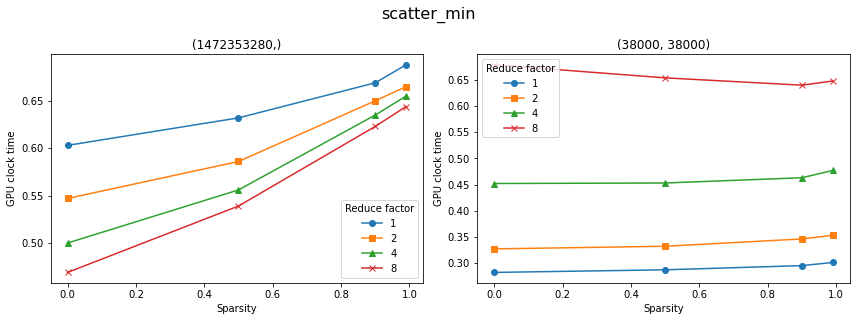

'scatter_mean'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(1472353280,)",0.0,0.703
1,1 square,"(36400, 36400)",0.0,0.146
2,1 LS,"(1472353280,)",0.5,0.703


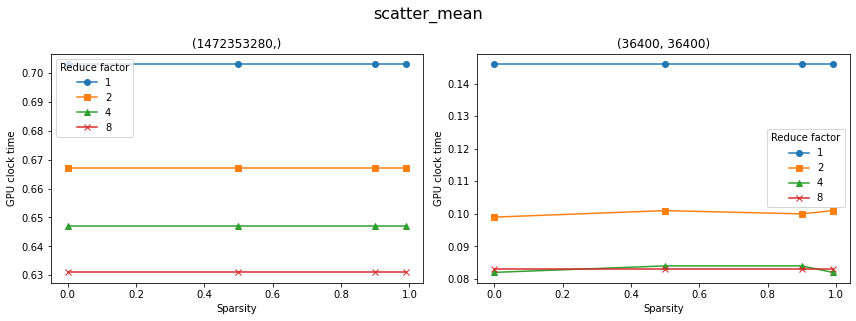

'scatter_add'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(2400576000,)",0.0,0.535 (0.522)
1,1 square,"(48000, 48000)",0.0,0.079 (0.066)
2,1 LS,"(2400576000,)",0.5,0.535 (0.522)


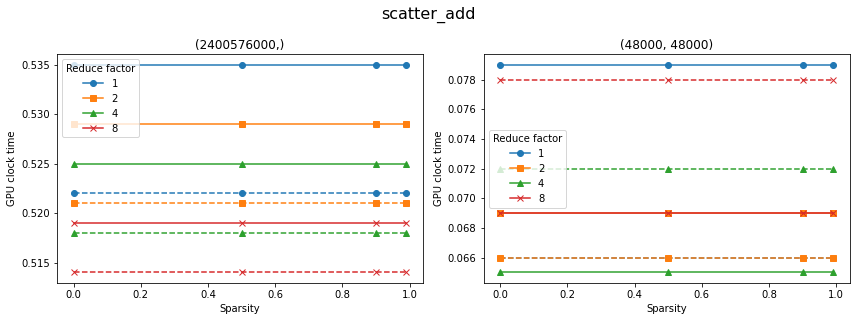

'scatter_multiply'

,"Reduce factor, shape",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1 LS,"(2400576000,)",0.0,0.520
1,1 square,"(48000, 48000)",0.0,0.176
2,1 LS,"(2400576000,)",0.5,0.520


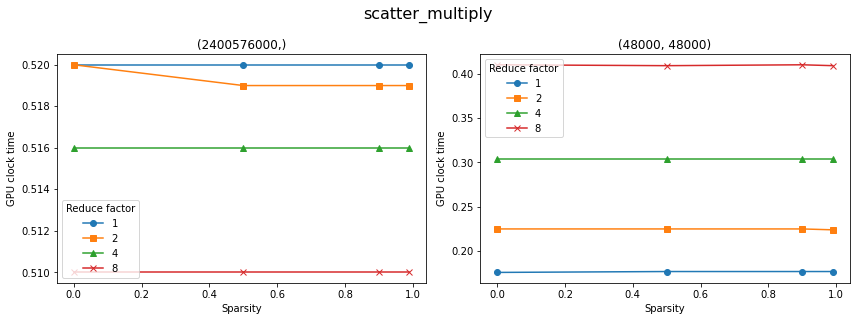

In [73]:
op2df, all_ops = reload_data()

for op_name in all_ops:
    if "scatter_" in op_name or "spline_" in op_name:
        display(op_name, op2df[op_name][:3])
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values=" ")
        plot_operation(df, plots_cols=["Input size (>95% mem util)*"], curves_cols=["Reduce factor"], op_name=op_name)

##### swap columns used for plots and curves

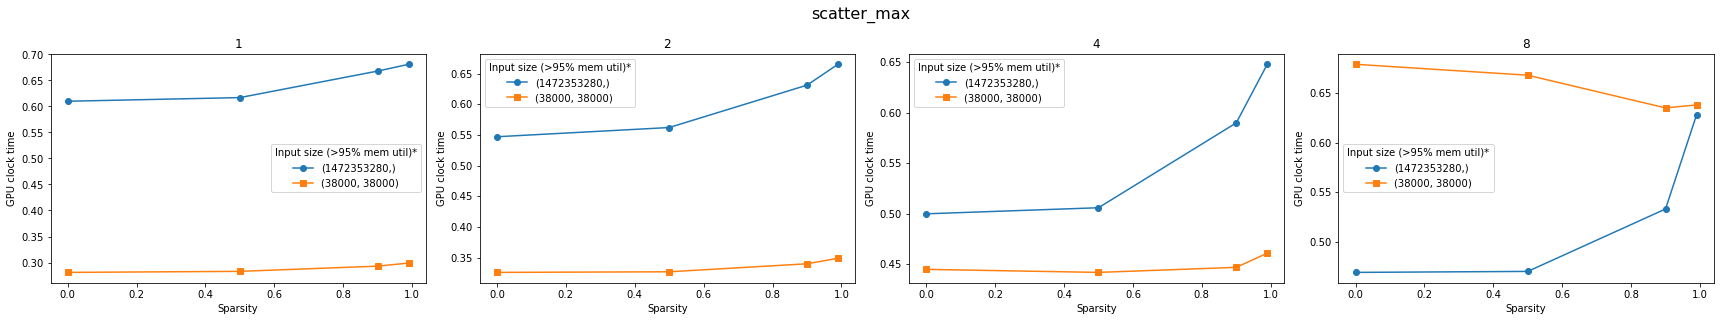

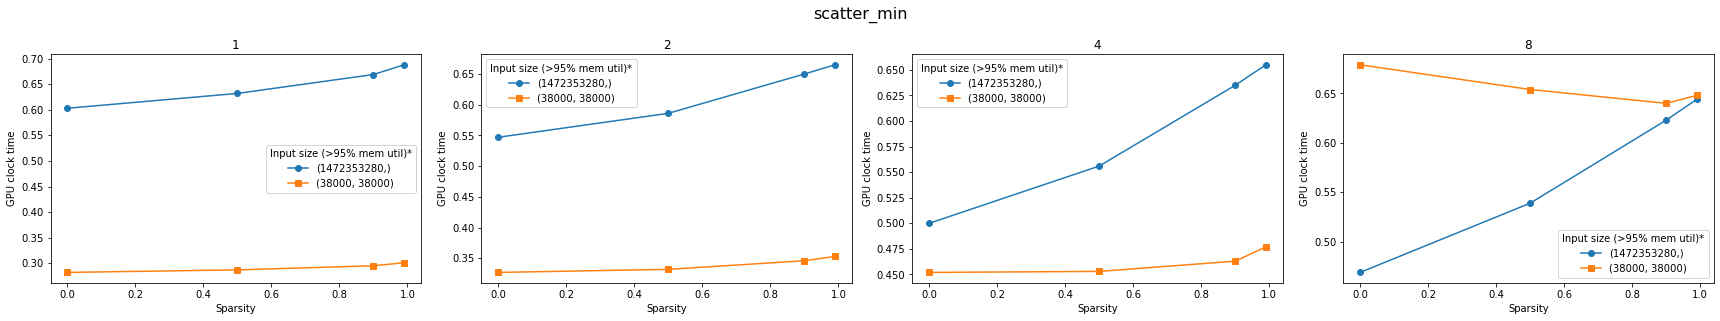

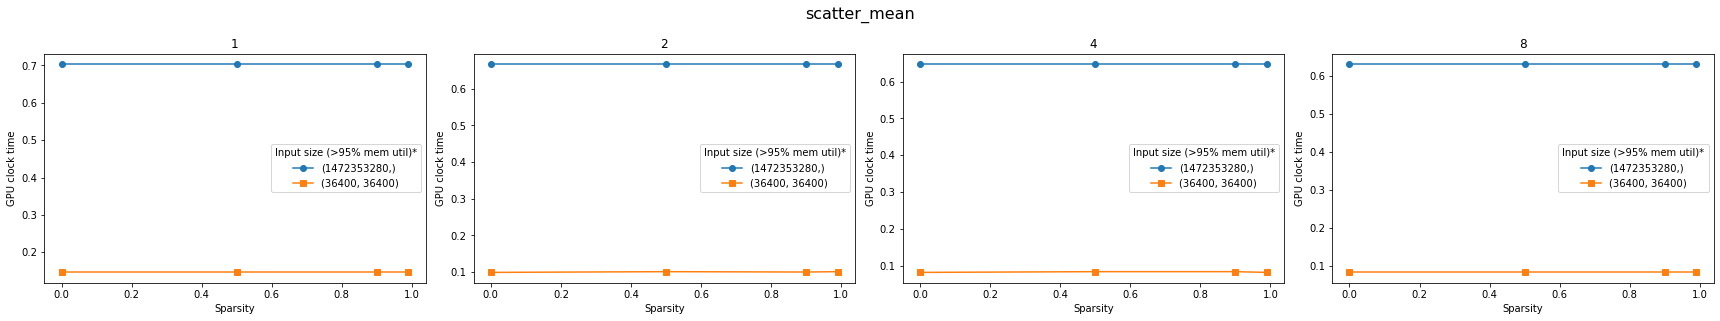

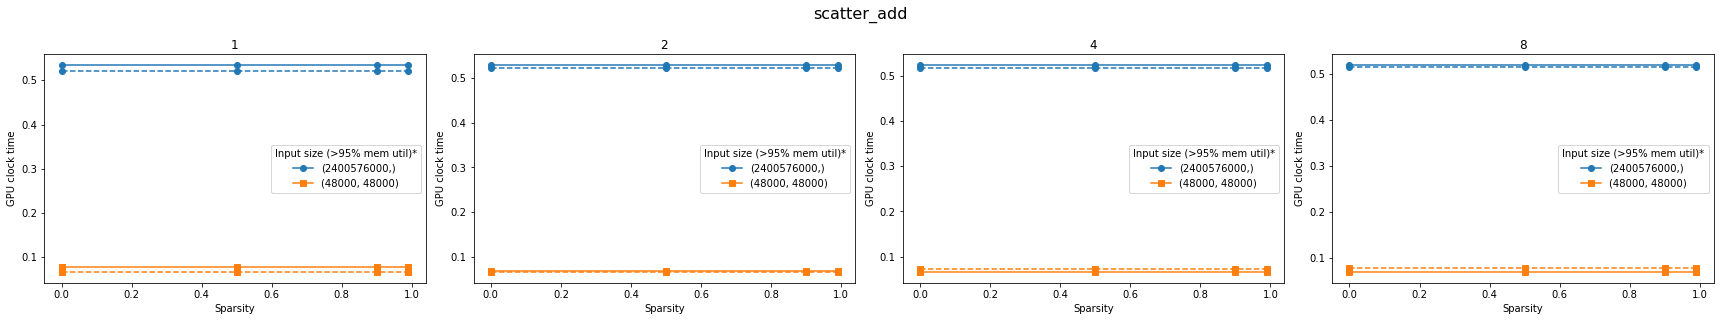

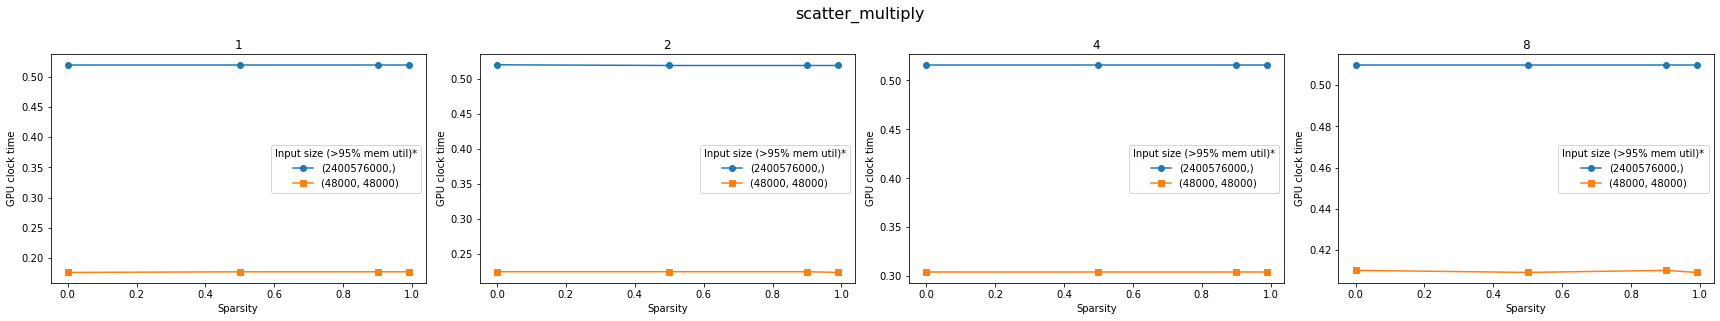

In [74]:
for op_name in all_ops:
    if "scatter_" in op_name:
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values=" ")
        plot_operation(df, plots_cols=["Reduce factor"], curves_cols=["Input size (>95% mem util)*"], op_name=op_name)

## `native_`

native_sort


,"Input dims, sort dim, stable",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0; True,"(960230400,)",0.0,17.212551
1,1; 0; False,"(960230400,)",0.0,17.210920
2,2; 0; True,"(28200, 28200)",0.0,0.196620


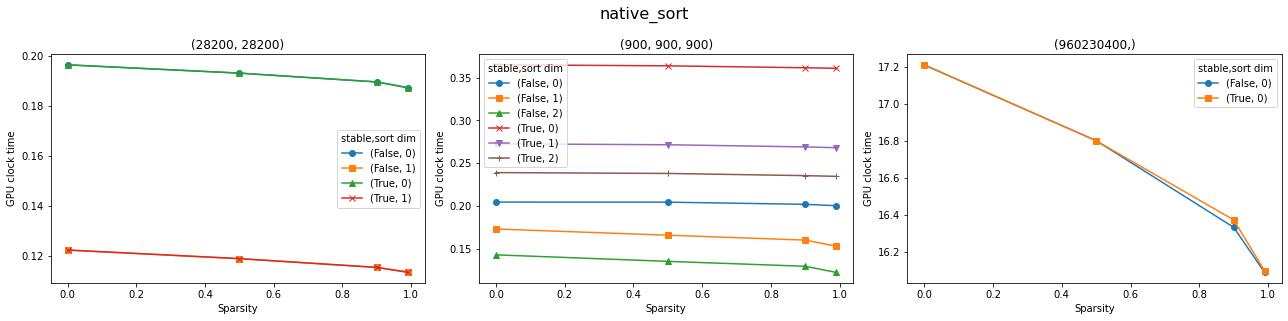

native_index_add_


,"Input dims, index dim",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0,"(1920460800,)",0.0,0.412412
1,2; 0,"(44000, 44000)",0.0,0.027599
2,2; 1,"(44000, 44000)",0.0,0.380915


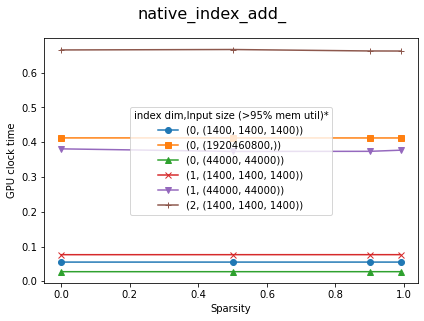

native_gather


,"Input dims, index dim",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0,"(2400576000,)",0.0,0.208929
1,2; 0,"(48000, 48000)",0.0,0.200370
2,2; 1,"(48000, 48000)",0.0,0.036084


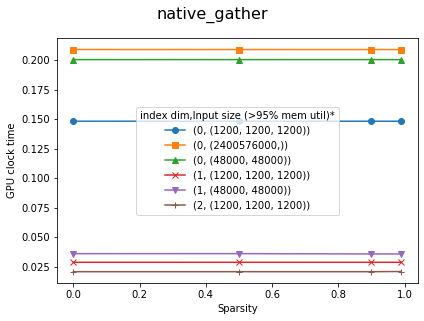

native_index_select


,"Input dims, index dim, reduce factor (RF)",Input size (>95% mem util)*,Sparsity,GPU clock time
0,1; 0; 1,"(2560614400,)",0.0,0.227669
1,1; 0; 2,"(2560614400,)",0.0,0.113962
2,1; 0; 4,"(2560614400,)",0.0,0.058981


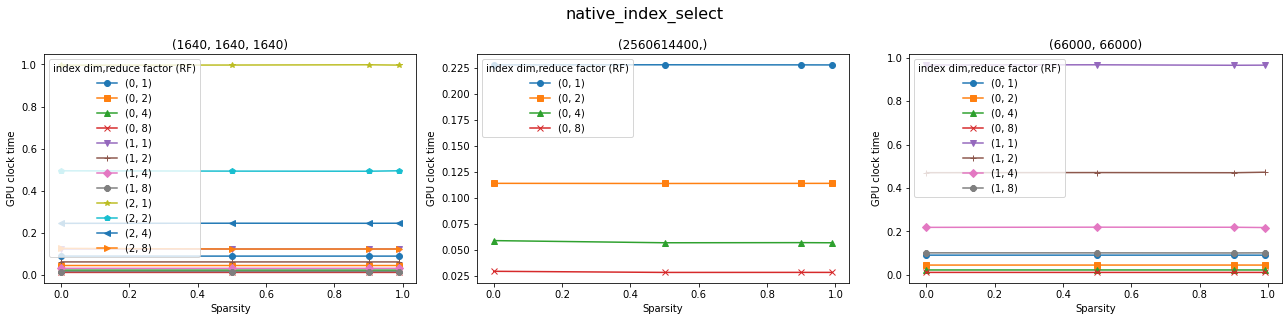

In [75]:
op2df, all_ops = reload_data()

for op_name in all_ops:
    if "native_" in op_name and "native_addmm" not in op_name:
        print(op_name)
        display(op2df[op_name][:3])
        old_cols = set(op2df[op_name].columns)
        df = split_column(op2df[op_name], i=0, col=None, delim_colname=", ", delim_values="; ")
        curves_cols = list(set(df.columns) - old_cols - {"GPU clock time PT", "Input dims"})
        plot_operation(df, 
                       plots_cols=None if op_name in ["native_index_add_", "native_gather"] else ["Input size (>95% mem util)*"], 
                       curves_cols=curves_cols + ["Input size (>95% mem util)*"] if op_name in ["native_index_add_", "native_gather"] else curves_cols, 
                       op_name=op_name)
        

## `native_addmm`

,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0 ; 0 ; 0,2.021733
1,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0 ; 0 ; 0,0.050985
2,3,"[(64000, 1), (64000, 64000), (64000, 1)]",0 ; 0 ; 0,0.013211
3,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0 ; 0 ; 0.5,2.019778
4,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0 ; 0 ; 0.5,0.051000
...,...,...,...,...
187,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0.99 ; 0.99 ; 0.9,0.051037
188,3,"[(64000, 1), (64000, 64000), (64000, 1)]",0.99 ; 0.99 ; 0.9,0.013270
189,3,"[(48000, 48000), (48000, 48000), (48000, 48000)]",0.99 ; 0.99 ; 0.99,2.018133
190,3,"[(64000, 64000), (64000, 1), (1, 64000)]",0.99 ; 0.99 ; 0.99,0.051037


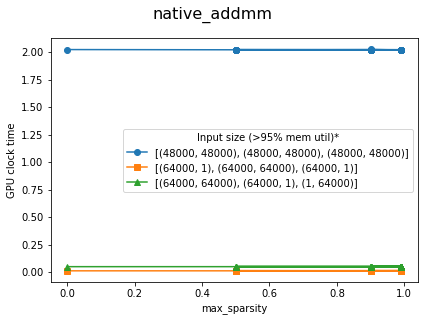

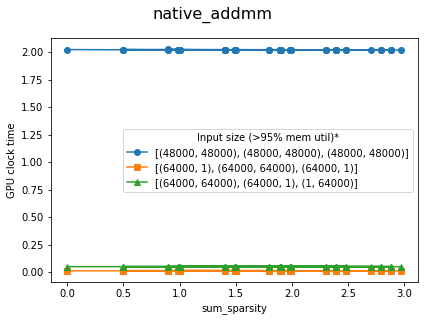

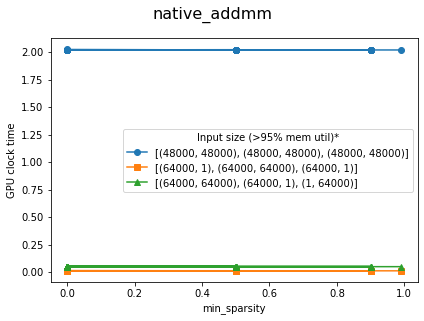

In [57]:
op_name = "native_addmm"
op2df, all_ops = reload_data()

display(op2df[op_name])

old_cols = set(op2df[op_name].columns)
df = split_column(op2df[op_name], i=2, col=None, delim_colname=", ", delim_values=" ; ")
df[["matB)", "matA", "Sparsities (input"]] = df[["matB)", "matA", "Sparsities (input"]].astype(float)
df["max_sparsity"] = df[["matB)", "matA", "Sparsities (input"]].max(axis=1)
df["sum_sparsity"] = df[["matB)", "matA", "Sparsities (input"]].sum(axis=1)
df["min_sparsity"] = df[["matB)", "matA", "Sparsities (input"]].min(axis=1)

for idx in ["max_sparsity", "sum_sparsity", "min_sparsity"]:
    markers, _  = get_markers_colors()
    df = df.set_index(idx)
    y_col = "GPU clock time"
    curves_cols = ["Input size (>95% mem util)*"]
    
    plot_operation(df, 
                   plots_cols=None, 
                   curves_cols=curves_cols, 
                   op_name=op_name)

In [67]:
op2df['sparse_spmm']

,Input dims,Input size (>95% mem util)*,"Sparsities (input, matA, matB)",GPU clock time
0,2,"[(1700, 1700), (1700, 1700)]",0.5 ; 0.5,0.10778759978711605 (0.010532762855291367)
1,2,"[(70400, 1), (1, 70400)]",0.5 ; 0.5,0.10241412092000246 (0.41660175286233425)
2,2,"[(29899, 29899), (29899, 1)]",0.5 ; 0.5,0.5089759286493063 (0.013162935525178908)
3,2,"[(1700, 1700), (1700, 1700)]",0.5 ; 0.9,0.1090115625411272 (0.010379308834671974)
4,2,"[(70400, 1), (1, 70400)]",0.5 ; 0.9,0.10133065562695265 (0.4181388132274151)
5,2,"[(29899, 29899), (29899, 1)]",0.5 ; 0.9,0.5089706405997276 (0.013153781648725271)
6,2,"[(1700, 1700), (1700, 1700)]",0.5 ; 0.99,0.10844247322529554 (0.010400177258998156)
7,2,"[(70400, 1), (1, 70400)]",0.5 ; 0.99,0.10152814816683531 (0.41620183549821377)
8,2,"[(29899, 29899), (29899, 1)]",0.5 ; 0.99,0.5095633808523417 (0.013170242682099343)
9,2,"[(1700, 1700), (1700, 1700)]",0.9 ; 0.5,0.015060406643897295 (0.0025096952356398108)
